In [1]:
import numpy as np
import torch
from deep_parity.boolean_cube import generate_all_binary_arrays, fourier_transform
import polars as pl

from plotnine import ggplot, aes, geom_line, geom_bar, geom_histogram, facet_wrap

In [2]:
n = 10
all_zero_one = torch.from_numpy(generate_all_binary_arrays(n)).to(torch.float64)
all_bn = torch.sign((-1 * all_zero_one) + 0.5)

In [3]:
from torch.nn.functional import relu

def _rlf(weights, vals):
    return relu(weights @ vals.T)


In [4]:
rlf = torch.vmap(_rlf, in_dims=(0, None))

In [5]:
weights = torch.from_numpy(generate_all_binary_arrays(n)).to(torch.float64)
weights = torch.sign((-1 * weights) + 0.5)

In [6]:
rand_vals = rlf(weights, all_bn)

In [7]:
ft = fourier_transform(rand_vals, n)

In [8]:
def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n)
    all_degrees = all_binary_data.sum(axis=1)
    all_parities = all_degrees % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
        'degree': all_degrees
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1))
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    ft = fourier_transform(tensor.T.to('cuda'))
    ft /= ft.mean(dim=0, keepdims=True)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('variable').agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    power_df = (
        data
        .select(pl.exclude('bits', 'parities', 'indices'))
        .unpivot(index='degree')
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('degree', 'variable').agg(pl.col('value').pow(2).sum())
        .join(total_power, on='variable', how='left')
        .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
    )
    return power_df

boolean_df = make_base_parity_dataframe(n)

In [12]:
ft_df = pl.DataFrame({str(i): vals.squeeze().numpy() for i, vals in enumerate(ft.split(1))})
data = (
    pl.concat([boolean_df, ft_df], how='horizontal')
    .unpivot(index=['bits', 'parities', 'degree', 'indices'])
    .with_columns(pl.col('variable').str.to_integer())
)
data.head()

bits,parities,degree,indices,variable,value
"array[u8, 10]",u64,u64,list[u32],i64,f64
"[0, 0, … 0]",0,0,[],0,39.375
"[0, 0, … 1]",1,1,[9],0,16.0
"[0, 0, … 0]",1,1,[8],0,16.0
"[0, 0, … 1]",0,2,"[8, 9]",0,4.375
"[0, 0, … 0]",1,1,[7],0,16.0


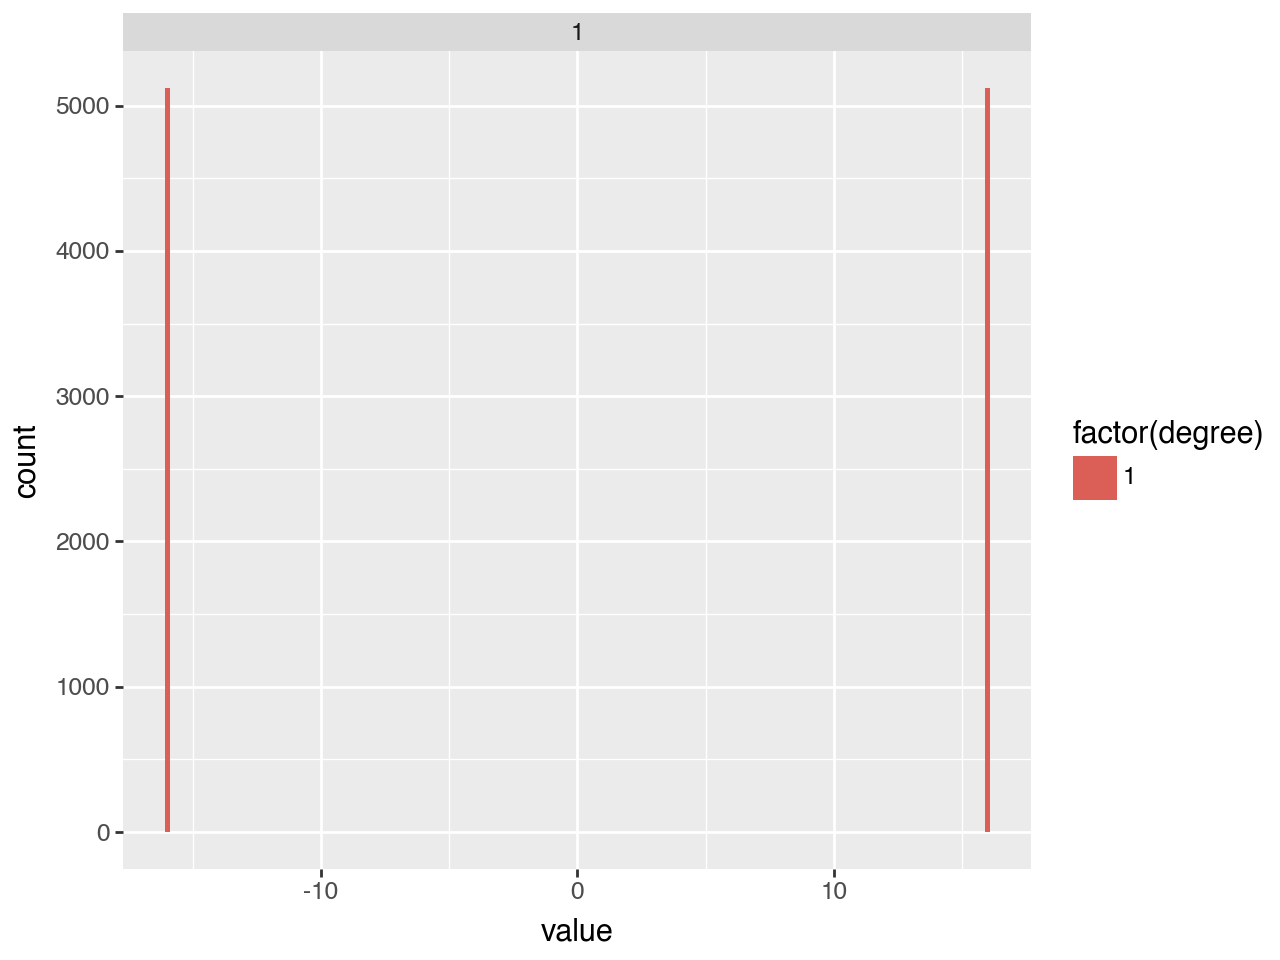

In [22]:
ggplot(data.filter(pl.col('degree').eq(1)), aes(x='value', fill='factor(degree)')) + geom_histogram(binwidth=0.2) + facet_wrap('~degree')

In [193]:
data.filter(pl.col('degree').eq(0) & pl.col('value').lt(0))

bits,parities,degree,indices,variable,value
"array[u8, 12]",u64,u64,list[u32],i64,f64
"[0, 0, … 0]",0,0,[],15,-0.875
"[0, 0, … 0]",0,0,[],23,-0.875
"[0, 0, … 0]",0,0,[],27,-0.875
"[0, 0, … 0]",0,0,[],29,-0.875
"[0, 0, … 0]",0,0,[],30,-0.875
…,…,…,…,…,…
"[0, 0, … 0]",0,0,[],4066,-0.375
"[0, 0, … 0]",0,0,[],4068,-0.375
"[0, 0, … 0]",0,0,[],4072,-0.375


In [25]:
2 ** 6 * 720

46080